# Analysis of comments provided by customers as at Jan 2020

In [ ]:
# "magic commands" to enable autoreload of your imported packages
%load_ext autoreload
%autoreload 2

In [8]:
# import libraries and packages 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import string

from nltk.corpus import stopwords 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.util import bigrams
from nltk.util import ngrams
from nltk import FreqDist
from nltk.collocations import *
from nltk.draw.dispersion import dispersion_plot

from wordcloud import WordCloud,STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from langdetect import detect

### 1. Import comments and listings data and merge

In [9]:
listings_jan20 = pd.read_csv('data/data_jan_listings.csv')
listings_jan20.shape

/Users/elg/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(87235, 106)

In [10]:
comments_jan20 = pd.read_csv('data/data_jan_reviews.csv')
comments_jan20.shape

(1549791, 6)

In [11]:
comments_jan20.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,11551,30672,2010-03-21,93896,Shar-Lyn,"The flat was bright, comfortable and clean and..."
1,11551,32236,2010-03-29,97890,Zane,We stayed with Adriano and Valerio for a week ...


In [12]:
# Filter out listings with 1 or 2 reviews and only keep useful columns for this exploration 
listings_jan20_no12 = listings_jan20[listings_jan20.number_of_reviews > 2]

listings_jan20_no12 = listings_jan20_no12[['id','host_id','review_scores_rating','neighbourhood_cleansed','bedrooms']]

listings_jan20_no12.shape

(51803, 5)

In [13]:
listings_jan20_no12.head(2)

,id,host_id,review_scores_rating,neighbourhood_cleansed,bedrooms
0,11551,43039,92.0,Lambeth,1.0
1,13913,54730,97.0,Islington,1.0


In [14]:
# Rename id = listing_id to merge with comments df 
listings_jan20_no12.columns = ['listing_id','host_id','review_scores_rating','location','bedrooms']

In [15]:
# Merge listings and comments 
comments_jan20_v2 = comments_jan20.merge(listings_jan20_no12, how='inner', on='listing_id')
comments_jan20_v2.shape

(1528564, 10)

In [ ]:
# Lost around 20k comments (1,2 reviews listings)

In [16]:
comments_jan20_v2.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,host_id,review_scores_rating,location,bedrooms
0,11551,30672,2010-03-21,93896,Shar-Lyn,"The flat was bright, comfortable and clean and...",43039,92.0,Lambeth,1.0
1,11551,32236,2010-03-29,97890,Zane,We stayed with Adriano and Valerio for a week ...,43039,92.0,Lambeth,1.0


In [17]:
comments_jan20_v2.isna().sum()

listing_id                0
id                        0
date                      0
reviewer_id               0
reviewer_name             0
comments                685
host_id                   0
review_scores_rating    200
location                  0
bedrooms                375
dtype: int64

In [18]:
# Remove rows with missing comments and/or review_scores 
comments_jan20_v3 = comments_jan20_v2.dropna()

In [19]:
comments_jan20_v3.isna().sum()

listing_id              0
id                      0
date                    0
reviewer_id             0
reviewer_name           0
comments                0
host_id                 0
review_scores_rating    0
location                0
bedrooms                0
dtype: int64

## 2. Take sample to speed up exploration

In [20]:
sample = comments_jan20_v3.sample(n = 230000, random_state=41) 

In [21]:
sample.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,host_id,review_scores_rating,location,bedrooms
355721,5638426,74517123,2016-05-15,53762803,Allan,"Nayna is an amazing host, she is very kind and...",13175343,96.0,Lambeth,1.0
1423524,33461094,582562716,2019-12-27,280991471,Oliver,The host canceled this reservation 3 days befo...,249264810,84.0,Newham,1.0


In [22]:
sample.location.value_counts()

Westminster               29392
Tower Hamlets             23519
Camden                    20898
Lambeth                   17320
Southwark                 16408
Kensington and Chelsea    15025
Islington                 14210
Hackney                   13474
Hammersmith and Fulham    12399
Wandsworth                 9410
Brent                      7061
Haringey                   5305
Newham                     5036
Lewisham                   4821
Ealing                     4778
Greenwich                  3867
Richmond upon Thames       3440
Barnet                     2994
Hounslow                   2984
Waltham Forest             2746
Merton                     2219
Hillingdon                 2131
Croydon                    1999
Redbridge                  1327
Kingston upon Thames       1232
City of London             1154
Bromley                    1122
Enfield                    1102
Harrow                      894
Sutton                      740
Barking and Dagenham        416
Havering

**Note: Also manually cleaned and labelled a sample of 10K comments: xxx.csv**

## 3. Preprocessing for comments analysis

### Remove NON ENGLISH comments

In [ ]:
# check what makes detect fail to run 
# text = sample['comments'].tolist()
# langdet = []                                                   

# for i in range(len(text)):                                         
#     try:       
#         lang=detect(text[i])                                      
#     except:                                                       
#         lang='error'                 
#         langdet.append(i) 
# langdet

In [23]:
def preprocessing1(text):
    if len(text) > 1 and type(text) == str:
        try:
            lang = detect(text)
        except:
            return 0
        if lang == 'en':
            return 1
    return 0

sample['comments_eng_flag'] = sample.comments.apply(preprocessing1)

sample.comments_eng_flag.value_counts(dropna=False)

1    198054
0     31946
Name: comments_eng_flag, dtype: int64

^ Around 14% are non english comments (aligned with manual checks)

In [24]:
sample_eng = sample[sample.comments_eng_flag == 1]
sample_eng.shape

(198054, 11)

### Remove AUTOMATICALLY GENERATED comments (containing 'This is an automated posting')

In [25]:
def preprocessing2(text):
    if 'This is an automated posting' in text: 
        return 1
    return 0

sample_eng['comments_aut_flag'] = sample_eng.comments.apply(preprocessing2)

sample_eng.comments_aut_flag.value_counts(dropna=False)

/Users/elg/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0    194794
1      3260
Name: comments_aut_flag, dtype: int64

In [26]:
check = sample_eng[sample_eng.comments_aut_flag == 1]
check.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments,host_id,review_scores_rating,location,bedrooms,comments_eng_flag,comments_aut_flag
1423524,33461094,582562716,2019-12-27,280991471,Oliver,The host canceled this reservation 3 days befo...,249264810,84.0,Newham,1.0,1,1
642024,13247797,92285772,2016-08-08,73733598,Estefania,The host canceled this reservation 7 days befo...,43121810,50.0,Haringey,1.0,1,1
1246128,26321398,303254049,2018-08-07,140207332,Maily,The host canceled this reservation 88 days bef...,197919413,99.0,Islington,1.0,1,1


In [27]:
sample_eng_f = sample_eng[sample_eng.comments_aut_flag == 0]
sample_eng_f.shape

(194794, 12)

### Remove PUNCTUATION and apply LOWERCASE

In [28]:
def preprocessing3(text):
    for punctuation in string.punctuation: 
        text = text.replace(punctuation, ' ') 
    
    return text.lower()
    
sample_eng_f['clean_comments'] = sample_eng_f.comments.apply(preprocessing3)
sample_eng_f.head(2)

/Users/elg/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,listing_id,id,date,reviewer_id,reviewer_name,comments,host_id,review_scores_rating,location,bedrooms,comments_eng_flag,comments_aut_flag,clean_comments
355721,5638426,74517123,2016-05-15,53762803,Allan,"Nayna is an amazing host, she is very kind and...",13175343,96.0,Lambeth,1.0,1,0,nayna is an amazing host she is very kind and...
444048,7794410,416334722,2019-02-24,32190926,Max,Friendly host and lovely house. Close to the t...,41026397,98.0,Bromley,0.0,1,0,friendly host and lovely house close to the t...


### Remove STOPWORDS

In [29]:
stop_words = set(stopwords.words('english')) 

In [30]:
def preprocessing4(text):
    word_tokens = word_tokenize(text) 
    text = [w for w in word_tokens if not w in stop_words]
    return ' '.join(text)

In [31]:
sample_eng_f['clean_comments2'] = sample_eng_f.clean_comments.apply(preprocessing4)
sample_eng_f.head(2)

/Users/elg/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,listing_id,id,date,reviewer_id,reviewer_name,comments,host_id,review_scores_rating,location,bedrooms,comments_eng_flag,comments_aut_flag,clean_comments,clean_comments2
355721,5638426,74517123,2016-05-15,53762803,Allan,"Nayna is an amazing host, she is very kind and...",13175343,96.0,Lambeth,1.0,1,0,nayna is an amazing host she is very kind and...,nayna amazing host kind room beautiful seclude...
444048,7794410,416334722,2019-02-24,32190926,Max,Friendly host and lovely house. Close to the t...,41026397,98.0,Bromley,0.0,1,0,friendly host and lovely house close to the t...,friendly host lovely house close train station...


In [32]:
sample_eng_f.shape

(194794, 14)

### Remove other common but not useful words in our context

In [129]:
other_words = ['website hidden airbnb','website', 'airbnb', 'hidden airbnb','recommend','recommended','definitely','next', 'highly recommend', 'highly', 'next time','enjoyed']

def preprocessing5(text):
    word_tokens = word_tokenize(text) 
    text = [w for w in word_tokens if not w in other_words]
    return ' '.join(text)

sample_eng_f['clean_comments3'] = sample_eng_f.clean_comments2.apply(preprocessing5)

sample_eng_f.shape

/Users/elg/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(194794, 15)

## 4. Sentiment Analysis

Manual labelling of 10K sample of comments showed that less than 5% of comments are negative. Therefore, i don't think that Sentiment Analysis at comment level will be very useful here..

In [ ]:
# import nltk
# nltk.download('vader_lexicon')

In [ ]:
# #Initialize sentiment analyzer
# sid = SentimentIntensityAnalyzer()

# #Assign sentiment to each comment
# def sentiment_assign(text):
#     sentiment = sid.polarity_scores(text)
#     return sentiment

# sample_eng['sentiment'] = sample_eng.clean_comments.apply(sentiment_assign)
# sample_eng[['clean_comments','sentiment']].head(2)

## 5. Bag-of-Words exploration

In [37]:
vectorizer = CountVectorizer(max_features = 12)

X = vectorizer.fit_transform(sample_eng_f.clean_comments2)
X.toarray()
pd.DataFrame(X.toarray(),columns = vectorizer.get_feature_names()).head()

,apartment,clean,flat,great,host,location,london,nice,place,room,stay,would
0,0,0,0,0,1,0,1,0,0,1,1,1
1,0,0,0,0,1,0,0,0,0,0,0,0
2,2,0,0,1,0,0,1,0,1,0,2,1
3,0,0,3,1,0,1,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,0,1


**One word only is not great, let's try 2 or 3 at a time and let's try with a different number of features**

**Note**: After exploration, 2 words is more readible and just as informative as 3 and 60 seems like an ideal number of features 

In [39]:
vectorize3 = CountVectorizer(ngram_range = (2,2), max_features=60)

X4 = vectorize3.fit_transform(sample_eng_f.clean_comments3)
X4.toarray()
Two_words = pd.DataFrame(X4.toarray(),columns = vectorize3.get_feature_names())
Two_words_agg = pd.DataFrame(Two_words.sum().sort_values(ascending=False))

In [40]:
Two_words_agg.reset_index(inplace=True)
Two_words_agg.columns = ['quote','count']

In [41]:
Two_words_agg

,quote,count
0,great location,19196
1,place stay,11137
2,great host,10054
3,would stay,9184
4,great place,8730
5,tube station,7543
6,central london,7423
7,walking distance,6617
8,great stay,6318
9,good location,6160


👇 **Group some categories together**

In [42]:
def transform_quote(quote):
    if quote in ['great location',\
                'good location',\
                'location great',\
                'well located',\
                'perfect location',\
                'location perfect']:
        quote_grouped = 'great location'
    elif quote in ['great host',\
                   'great hosts',\
                   'lovely host',\
                   'lovely hosts']:
        quote_grouped = 'great host'
    elif quote == 'clean comfortable':
        quote_grouped = 'comfortable'
    elif quote in ['bed comfortable',\
                    'comfortable bed',\
                    'comfy bed']:
        quote_grouped = 'comfortable bed'
    elif quote in ['room clean',\
                    'place clean',\
                    'clean tidy',\
                    'nice clean',
                    'apartment clean',\
                    'clean well',\
                    'flat clean']:
        quote_grouped = 'clean'
    elif quote in ['easy get',\
                    'easy access']:
        quote_grouped = 'easy access'
    elif quote in ['everything needed',\
                    'everything need']:
        quote_grouped = 'everything needed'
    elif quote in ['great place',\
                    'place great',\
                    'nice place', \
                    'really nice']:
        quote_grouped = 'nice place'
    elif quote in ['tube station',\
                    'close tube',\
                    'underground station']:
        quote_grouped = 'close tube'
    elif quote in ['walking distance',\
                    'minute walk',\
                    'minutes walk',\
                    'short walk',\
                    'min walk']:
        quote_grouped = 'walking distance'
    elif quote in ['value money',\
                    'great value',\
                    'good value']:
        quote_grouped = 'value money'
    elif quote in ['apartment great',\
                    'flat great']:
        quote_grouped = 'apartment great'
    elif quote in ['place stay',\
                    'would stay',\
                    'great stay',\
                    'stay london',\
                    'come back',\
                    'gave us',\
                    'great time',\
                    'living room',\
                    'us feel',\
                    'walk away',\
                    'visit london',\
                    'stay would',\
                    'made us',\
                    'really stay',\
                    'time london']:
        quote_grouped = 'remove'
    else:
        quote_grouped = quote
    
    return quote_grouped

In [43]:
Two_words_agg['quote_grouped'] = Two_words_agg.quote.apply(transform_quote)

In [44]:
Two_words_agg_filter = Two_words_agg[Two_words_agg.quote_grouped != 'remove']

Two_words_agg_final = Two_words_agg_filter.groupby(Two_words_agg.quote_grouped)['count'].sum().sort_values(ascending=False)

In [ ]:
# tf_idf_vectorizer = TfidfVectorizer(max_features = 12)

# X2 = tf_idf_vectorizer.fit_transform(sample.clean_comments3)

# X2.toarray()

# pd.DataFrame(X2.toarray(),columns = tf_idf_vectorizer.get_feature_names()).head()

*****************************************************************************
*****************************************************************************
**Check if results vary if we filter on listings with high review score first**

**Note**: answer is no.. no need to filter on review score

In [45]:
sample_eng_f.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,host_id,review_scores_rating,location,bedrooms,comments_eng_flag,comments_aut_flag,clean_comments,clean_comments2,clean_comments3
355721,5638426,74517123,2016-05-15,53762803,Allan,"Nayna is an amazing host, she is very kind and...",13175343,96.0,Lambeth,1.0,1,0,nayna is an amazing host she is very kind and...,nayna amazing host kind room beautiful seclude...,nayna amazing host kind room beautiful seclude...
444048,7794410,416334722,2019-02-24,32190926,Max,Friendly host and lovely house. Close to the t...,41026397,98.0,Bromley,0.0,1,0,friendly host and lovely house close to the t...,friendly host lovely house close train station...,friendly host lovely house close train station...


In [46]:
sample_eng_f.shape

(194794, 15)

In [47]:
sample_eng_f.review_scores_rating.describe(percentiles=[0.10,0.25,0.50,0.75,0.90])

count    194794.000000
mean         93.645056
std           5.455746
min          20.000000
10%          86.000000
25%          91.000000
50%          95.000000
75%          98.000000
90%          99.000000
max         100.000000
Name: review_scores_rating, dtype: float64

**Let's keep the top 10%**

In [48]:
top_score_sample = sample_eng_f[sample_eng_f.review_scores_rating >= 99]
top_score_sample.shape

(29532, 15)

In [49]:
vectorize3 = CountVectorizer(ngram_range = (2,2), max_features=60)

X5 = vectorize3.fit_transform(top_score_sample.clean_comments3)
X5.toarray()
Two_words_top_score = pd.DataFrame(X5.toarray(),columns = vectorize3.get_feature_names())
Two_words_top_score_agg = pd.DataFrame(Two_words_top_score.sum().sort_values(ascending=False))

In [50]:
Two_words_top_score_agg

,0
great location,2274
great host,1858
place stay,1845
would stay,1488
great place,1294
central london,1278
come back,1029
tube station,1004
great stay,984
stay london,943


*****************************************************************************
*****************************************************************************
**Check whether results vary by cluster**

**Note**: Answer is yes! See section 6 for final csv file creation

In [51]:
# Import file with cluster for each listing Id (provided by Leone)
clusters = pd.read_csv('data/clusters.csv')
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51748 entries, 0 to 51747
Data columns (total 6 columns):
Unnamed: 0              51748 non-null int64
location                51748 non-null object
price-boroughwise       51748 non-null object
property_type           51726 non-null object
review_scores_rating    51748 non-null float64
listing_id              51748 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.4+ MB


In [52]:
# Convert listing_id from float to int in cluster table 
clusters.listing_id = clusters.listing_id.map(lambda x: int(x))

In [53]:
# Concatenate 3 fields to create cluster label
clusters['cluster'] = "L:" + clusters['location'] + "_P:" + clusters['price-boroughwise'] + "_S:" + clusters['property_type']
clusters.cluster.value_counts().sort_values(ascending=False)

L:Westminster_P:very_expensive_S:large               1039
L:Tower Hamlets_P:cheap_S:room                       1001
L:Tower Hamlets_P:very_cheap_S:room                   992
L:Westminster_P:very_cheap_S:room                     970
L:Westminster_P:cheap_S:small                         788
L:Tower Hamlets_P:very_expensive_S:large              734
L:Westminster_P:expensive_S:large                     730
L:Westminster_P:average_S:small                       718
L:Hackney_P:very_cheap_S:room                         709
L:Camden_P:very_cheap_S:room                          691
L:Camden_P:very_expensive_S:large                     649
L:Hackney_P:very_expensive_S:large                    641
L:Kensington and Chelsea_P:very_expensive_S:large     630
L:Southwark_P:very_cheap_S:room                       616
L:Lambeth_P:cheap_S:room                              601
L:Tower Hamlets_P:average_S:small                     586
L:Tower Hamlets_P:expensive_S:small                   557
L:Hackney_P:ch

In [54]:
# Merge with sample_eng_f
clusters_F = clusters[['listing_id','cluster']].copy()
cluster_comments_samp = sample_eng_f.merge(clusters_F, how='inner', on = 'listing_id')
cluster_comments_samp.shape

(194792, 16)

In [55]:
# Check how the review score varies for clusters with enough comment volumes 
# Will use some of these to understand how the word cloud would change 
volume = pd.DataFrame(cluster_comments_samp.cluster.value_counts())
score = pd.DataFrame(cluster_comments_samp.groupby(cluster_comments_samp.cluster)['review_scores_rating'].mean())
score.shape, volume.shape

((432, 1), (432, 1))

In [56]:
volume.reset_index(inplace=True)
score.reset_index(inplace=True)
volume.columns = ['cluster','count']
score.columns = ['cluster','mean_score']

In [57]:
volume.head(2)

,cluster,count
0,L:Westminster_P:very_cheap_S:room,6274
1,L:Tower Hamlets_P:very_cheap_S:room,4538


In [58]:
score.head(2)

,cluster,mean_score
0,L:Barking and Dagenham_P:average_S:room,94.802817
1,L:Barking and Dagenham_P:average_S:small,93.000000


In [59]:
check = volume.merge(score,how='inner',on='cluster')
check.shape

(432, 3)

In [131]:
check.to_csv('check_cluster_count.csv')

With reasonable volumes:
- lower review score > L:Westminster_P:cheap_S:small
- mid review score > L:Hammersmith and Fulham_P:very_cheap_S:room
- higher review score > L:Wandsworth_P:cheap_S:room

In [61]:
low_rev_clust = cluster_comments_samp[cluster_comments_samp.cluster == 'L:Westminster_P:cheap_S:small']
mid_rev_clust = cluster_comments_samp[cluster_comments_samp.cluster == 'L:Hammersmith and Fulham_P:very_cheap_S:room']
high_rev_clust = cluster_comments_samp[cluster_comments_samp.cluster == 'L:Wandsworth_P:cheap_S:room']

low_rev_clust.shape, mid_rev_clust.shape, high_rev_clust.shape

((2952, 16), (3292, 16), (2272, 16))

In [62]:
# Function to group some of the word associations that commonly come out of countvectorizer
def transform_quote(quote):
    if quote in ['great location',\
                'good location',\
                'location great',\
                'well located',\
                'perfect location',\
                'location perfect',\
                'fantastic location',\
                'excellent location',\
                'location good',\
                'location perfect',\
                'location excellent',\
                'amazing location',\
                'location amazing']:
        quote_grouped = 'great location'
    elif quote in ['location near',\
                   'location close',\
                   'close location',\
                    'near location']:
        quote_grouped = 'location near'
    elif quote in ['great host',\
                   'great hosts',\
                   'lovely host',\
                   'lovely hosts',\
                   'wonderful host',\
                   'wonderful hosts',\
                  'perfect host',\
                  'perfect hosts']:
        quote_grouped = 'great host'
    elif quote in ['clean comfortable',\
                   'room comfortable']:
        quote_grouped = 'comfortable'
    elif quote in ['bed comfortable',\
                    'comfortable bed',\
                    'comfy bed']:
        quote_grouped = 'comfortable bed'
    elif quote in ['room clean',\
                    'place clean',\
                    'clean tidy',\
                    'nice clean',
                    'apartment clean',\
                    'clean well',\
                    'flat clean',\
                    'clean room']:
        quote_grouped = 'clean'
    elif quote in ['easy get',\
                    'easy access']:
        quote_grouped = 'easy access'
    elif quote in ['everything needed',\
                    'everything need']:
        quote_grouped = 'everything needed'
    elif quote in ['great place',\
                    'place great',\
                    'nice place', \
                    'really nice']:
        quote_grouped = 'nice place'
    elif quote in ['tube station',\
                    'close tube',\
                    'underground station',\
                    'tube stations',\
                    'walk tube']:
        quote_grouped = 'close tube station'
    elif quote in ['walking distance',\
                    'minute walk',\
                    'minutes walk',\
                    'short walk',\
                    'min walk']:
        quote_grouped = 'walking distance'
    elif quote in ['value money',\
                    'great value',\
                    'good value']:
        quote_grouped = 'value money'
    elif quote in ['apartment great',\
                    'flat great']:
        quote_grouped = 'apartment great'
    elif quote in ['place stay',\
                    'would stay',\
                    'great stay',\
                    'stay london',\
                    'come back',\
                    'gave us',\
                    'great time',\
                    'living room',\
                    'us feel',\
                    'walk away',\
                    'visit london',\
                    'stay would',\
                    'made us',\
                    'really stay',\
                    'time london',\
                    'made feel',\
                    'really stay',\
                    'felt like',\
                    'check check',\
                    'trip london',\
                    'london trip']:
        quote_grouped = 'remove'
    else:
        quote_grouped = quote
    
    return quote_grouped

In [63]:
# Function to return most common 2 words associations 
def count_2words(comment_data, comment_column, nb_features):
    data = comment_data.copy()
    
    vectorize_2w = CountVectorizer(ngram_range = (2,2), max_features=nb_features)
    vect_data = vectorize_2w.fit_transform(data[comment_column])
    vect_data_df = pd.DataFrame(vect_data.toarray(),columns = vectorize_2w.get_feature_names())
    vect_data_df_agg = pd.DataFrame(vect_data_df.sum().sort_values(ascending=False))
    
    return vect_data_df_agg

In [64]:
# Function to prepare data for word cloud (takes output from previous function as input 
# and group similar 2 word associations together, aggregate again and return)
def pre_process(vectorized_data):
    data = vectorized_data.copy()
    
    data.reset_index(inplace=True)
    data.columns = ['quote','count']
    data['quote_grouped'] = data.quote.apply(transform_quote)
    data = data[data.quote_grouped != 'remove']
    final = data.groupby(data.quote_grouped)['count'].sum().sort_values(ascending=False)
    
    return final

In [65]:
vect_data_lowR_clus = count_2words(low_rev_clust,'clean_comments3',60)
lowR_clus_word_count = pre_process(vect_data_lowR_clus)
lowR_clus_word_count

quote_grouped
great location        1160
walking distance       392
nice place             319
close tube station     272
clean                  244
everything needed      194
hyde park              175
apartment great        138
location near          131
easy access            128
paddington station     117
great host             114
central london         106
value money             93
victoria station        81
well equipped           72
notting hill            64
short stay              60
shops restaurants       58
comfortable             50
quick respond           50
public transport        50
two people              46
place perfect           46
central location        44
within walking          44
Name: count, dtype: int64

In [66]:
vect_data_highR_clus = count_2words(high_rev_clust,'clean_comments3',60)
highR_clus_word_count = pre_process(vect_data_highR_clus)
highR_clus_word_count

quote_grouped
great location        310
great host            274
nice place            229
clean                 209
walking distance      201
comfortable bed       141
comfortable           119
central london         91
easy access            85
battersea park         82
everything needed      77
clapham junction       74
value money            69
feel welcome           66
close tube station     61
public transport       53
bus stop               52
feel home              52
like home              48
friendly helpful       47
train station          44
private bathroom       43
lovely home            41
friendly welcoming     38
bus stops              33
comfortable room       32
Name: count, dtype: int64

In [67]:
wordcloud_lowR = WordCloud(background_color="white",collocation_threshold=5).generate_from_frequencies(lowR_clus_word_count)
wordcloud_highR = WordCloud(background_color="white",collocation_threshold=10).generate_from_frequencies(highR_clus_word_count)

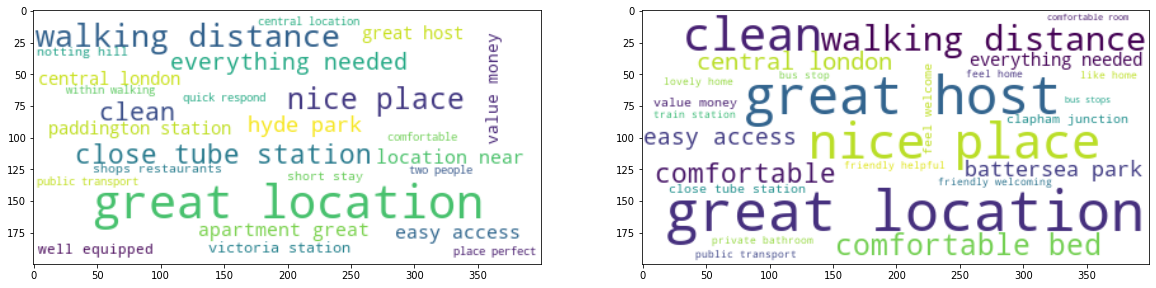

In [68]:
fig = plt.figure(figsize=(20,10))
grid = plt.GridSpec(1,2, wspace=0.2, hspace=0.5)

fig.add_subplot(grid[0,0]).imshow(wordcloud_lowR, interpolation="bilinear")
fig.add_subplot(grid[0,1]).imshow(wordcloud_highR, interpolation="bilinear")

# LEFT: L:Westminster  P:cheap  S:small                       RIGHT: L:Wandsworth   P:cheap   S:room

## 6. Clean code to create csv file with most common word associations and associated counts per cluster

### Add Cluster label and Cluster Id  (provided by Leone) to comments sample

In [118]:
sample_eng_f.shape, sample_eng_f.columns

((194794, 15),
 Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments',
        'host_id', 'review_scores_rating', 'location', 'bedrooms',
        'comments_eng_flag', 'comments_aut_flag', 'clean_comments',
        'clean_comments2', 'clean_comments3'],
       dtype='object'))

In [110]:
# read in csv files provided by Leone with cluster related info 
clusters = pd.read_csv('data/clusters.csv')
clusters_id = pd.read_csv('data/clusters_table.csv')

In [111]:
# Concatenate 3 fields to create cluster label  
clusters['cluster'] = "L:" + clusters['location'] + "_P:" + clusters['price-boroughwise'] + "_S:" + clusters['property_type']
clusters_id['cluster'] = "L:" + clusters_id['location'] + "_P:" + clusters_id['price-boroughwise'] + "_S:" + clusters_id['property_type']

# Only keep required info from both cluster tables 
clusters = clusters[['listing_id','cluster']]
clusters_id = clusters_id[['cluster','cluster_id']]

# Convert listing_id from float to int in cluster table to merge with comment table 
clusters.listing_id = clusters.listing_id.map(lambda x: int(x))

In [112]:
clusters.shape, clusters_id.shape

((51748, 2), (447, 2))

In [117]:
# Merge clusters and clusters_id 
cluster_F = clusters.merge(clusters_id, how='inner', on='cluster')
cluster_F.shape, cluster_F.head(2)

((51726, 3),
    listing_id                        cluster  cluster_id
 0       11551  L:Lambeth_P:expensive_S:small         287
 1       53245  L:Lambeth_P:expensive_S:small         287)

In [121]:
# Merge cluster_F with comments sample 
cluster_comments = sample_eng_f.merge(cluster_F, how = 'inner', on = 'listing_id')

cluster_comments.shape

(194792, 17)

In [122]:
cluster_comments.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments,host_id,review_scores_rating,location,bedrooms,comments_eng_flag,comments_aut_flag,clean_comments,clean_comments2,clean_comments3,cluster,cluster_id
0,5638426,74517123,2016-05-15,53762803,Allan,"Nayna is an amazing host, she is very kind and...",13175343,96.0,Lambeth,1.0,1,0,nayna is an amazing host she is very kind and...,nayna amazing host kind room beautiful seclude...,nayna amazing host kind room beautiful seclude...,L:Lambeth_P:very_cheap_S:room,289
1,5638426,111216552,2016-10-30,91901024,Joanne,Nayna was very welcoming and helpful. She gave...,13175343,96.0,Lambeth,1.0,1,0,nayna was very welcoming and helpful she gave...,nayna welcoming helpful gave perfect guidance ...,nayna welcoming helpful gave perfect guidance ...,L:Lambeth_P:very_cheap_S:room,289
2,5638426,79001035,2016-06-10,53324402,Evelyne,"Short and sweet, I enjoyed my stay at Nayna's ...",13175343,96.0,Lambeth,1.0,1,0,short and sweet i enjoyed my stay at nayna s ...,short sweet enjoyed stay nayna place lot room ...,short sweet stay nayna place lot room situated...,L:Lambeth_P:very_cheap_S:room,289


In [156]:
volume = pd.DataFrame(cluster_comments.cluster.value_counts())
score = pd.DataFrame(cluster_comments.groupby(cluster_comments.cluster)['review_scores_rating'].mean())
volume.reset_index(inplace=True)
score.reset_index(inplace=True)
volume.columns = ['cluster','count']
score.columns = ['cluster','mean_score']
pick_clusters = volume.merge(score,how='inner',on='cluster')
pick_clusters_F = pick_clusters.merge(clusters_id, how='inner', on='cluster')

In [161]:
pick_clusters_F.to_csv('pick_clusters.csv')

### Functions used to create word counts

In [246]:
# Function 1: Groups the word associations that commonly come out of countvectorizer and that are similar 

def transform_quote(quote):
    if quote in ['great location',\
                'good location',\
                'location great',\
                'well located',\
                'perfect location',\
                'location perfect',\
                'fantastic location',\
                'excellent location',\
                'location good',\
                'location perfect',\
                'location excellent',\
                'amazing location',\
                'location amazing',\
                'convenient location']:
        quote_grouped = 'great location'
    elif quote in ['location near',\
                   'location close',\
                   'close location',\
                    'near location']:
        quote_grouped = 'location near'
    elif quote in ['great host',\
                   'great hosts',\
                   'lovely host',\
                   'lovely hosts',\
                   'wonderful host',\
                   'wonderful hosts',\
                  'perfect host',\
                  'perfect hosts',\
                  'nice host',\
                  'welcoming host',\
                  'welcoming hosts']:
        quote_grouped = 'great host'
    elif quote in ['clean comfortable',\
                   'room comfortable']:
        quote_grouped = 'comfortable'
    elif quote in ['bed comfortable',\
                    'comfortable bed',\
                    'comfy bed']:
        quote_grouped = 'comfortable bed'
    elif quote in ['room clean',\
                    'place clean',\
                    'clean tidy',\
                    'nice clean',
                    'apartment clean',\
                    'clean well',\
                    'flat clean',\
                    'clean room']:
        quote_grouped = 'clean'
    elif quote in ['easy get',\
                    'easy access']:
        quote_grouped = 'easy access'
    elif quote in ['everything needed',\
                    'everything need']:
        quote_grouped = 'everything needed'
    elif quote in ['great place',\
                    'place great',\
                    'nice place', \
                    'really nice',\
                      'good place',\
                      'place perfect',\
                      'place good']:
        quote_grouped = 'nice place'
    elif quote in ['tube station',\
                    'close tube',\
                    'underground station',\
                    'tube stations',\
                    'walk tube',\
                      'close underground']:
        quote_grouped = 'close tube station'
    elif quote in ['walking distance',\
                    'minute walk',\
                    'minutes walk',\
                    'short walk',\
                    'min walk']:
        quote_grouped = 'walking distance'
    elif quote in ['value money',\
                    'great value',\
                    'good value']:
        quote_grouped = 'value money'
    elif quote in ['apartment great',\
                    'flat great']:
        quote_grouped = 'apartment great'
    elif quote in ['central london',\
                   'central location',\
                  'centrally located',\
                  'location central']:
        quote_grouped = 'central location'
    elif quote in ['feel home','like home']:
        quote_grouped = 'like home'
    elif quote in ['good communication','great communication']:
        quote_grouped = 'good communication'
    elif quote in ['king cross',\
                  'kings cross',\
                  'cross st',\
                  'cross station',\
                  'st pancras']:
        quote_grouped = 'kings cross st'
    elif quote in ['place stay',\
                    'would stay',\
                    'great stay',\
                    'stay london',\
                    'come back',\
                    'gave us',\
                    'great time',\
                    'living room',\
                    'us feel',\
                    'walk away',\
                    'visit london',\
                    'stay would',\
                    'made us',\
                    'really stay',\
                    'time london',\
                    'made feel',\
                    'really stay',\
                    'felt like',\
                    'check check',\
                    'trip london',\
                    'london trip',\
                      'good stay',\
                      'really good',\
                      'lovely stay',\
                      'andrea sarah',\
                      'seb andie',\
                      'annie belinda']:
        quote_grouped = 'remove'
    else:
        quote_grouped = quote
    
    return quote_grouped

In [239]:
# Function 2: Returns most common 2 words associations 

def count_2words(comment_data, comment_column, nb_features):
    data = comment_data.copy()
    
    vectorize_2w = CountVectorizer(ngram_range = (2,2), max_features=nb_features)
    vect_data = vectorize_2w.fit_transform(data[comment_column])
    vect_data_df = pd.DataFrame(vect_data.toarray(),columns = vectorize_2w.get_feature_names())
    vect_data_df_agg = pd.DataFrame(vect_data_df.sum().sort_values(ascending=False))
    
    return vect_data_df_agg

In [240]:
# Function 3: Prepare data series for word cloud (takes output from previous function as input 
# and group similar 2 word associations together using function 1, aggregates again and return)

def pre_process(vectorized_data):
    data = vectorized_data.copy()
    
    data.reset_index(inplace=True)
    data.columns = ['quote','count']
    data['quote_grouped'] = data.quote.apply(transform_quote)
    data = data[data.quote_grouped != 'remove']
    final = data.groupby(data.quote_grouped)['count'].sum().sort_values(ascending=False)
    
    return final

In [241]:
# Function 4: Run Functions 2 and 3 for a given cluster id and add a cloumn with column ID
# To run accross all clusters, set clust_id to 500
# Returns a dataframe 

def produce_counts(comment_data, clust_id, comment_column, nb_features):
    if clust_id != 500:
        comment_data_subs = comment_data[comment_data.cluster_id == clust_id]
    else:
        comment_data_subs = comment_data
    counts = count_2words(comment_data_subs,comment_column,nb_features)
    counts_pre_processes = pd.DataFrame(pre_process(counts))
    counts_pre_processes.reset_index(inplace=True)
    counts_pre_processes.columns = ['quotes','count']
    clust_id_list = [clust_id]*len(counts_pre_processes)
    counts_pre_processes['cluster_id'] = clust_id_list
    
    return counts_pre_processes

### Generate word counts for subset of clusters 

In [242]:
label_list = ['L:Westminster_P:very_cheap_S:room',\
            'L:Tower Hamlets_P:very_cheap_S:room',\
            'L:Tower Hamlets_P:cheap_S:room',\
            'L:Camden_P:very_cheap_S:room',\
            'L:Lambeth_P:cheap_S:room',\
            'L:Camden_P:cheap_S:room',\
            'L:Southwark_P:cheap_S:room',\
            'L:Hammersmith and Fulham_P:very_cheap_S:room',\
            'L:Southwark_P:very_cheap_S:room',\
            'L:Lambeth_P:very_cheap_S:room',\
            'L:Westminster_P:cheap_S:small',\
            'L:Hackney_P:cheap_S:room',\
            'L:Islington_P:very_cheap_S:room',\
            'L:Kensington and Chelsea_P:very_cheap_S:room',\
            'L:Westminster_P:cheap_S:room',\
            'L:Islington_P:cheap_S:room',\
            'L:Westminster_P:very_expensive_S:large',\
            'L:Hackney_P:very_cheap_S:room',\
            'L:Westminster_P:expensive_S:large',\
            'L:Westminster_P:average_S:small',\
            'L:Wandsworth_P:cheap_S:room']

label_ids = [442,\
            398,\
            392,\
            71,\
            283,\
            65,\
            365,\
            172,\
            371,\
            289,\
            437,\
            151,\
            247,\
            262,\
            436,\
            241]

In [247]:
# Create dictionnary containing word counts for all cluster ids in label_ids
dict_clus_word_counts = {}
for id in label_ids:
    dict_clus_word_counts[f'words_{id}'] = produce_counts(cluster_comments,id,'clean_comments3',60)

In [248]:
word_counts_all = produce_counts(cluster_comments,500,'clean_comments3',60)

In [249]:
dict_clus_word_counts['words_241']

,quotes,count,cluster_id
0,great location,531,241
1,kings cross st,328,241
2,great host,282,241
3,nice place,276,241
4,walking distance,246,241
5,clean,187,241
6,close tube station,156,241
7,comfortable bed,130,241
8,everything needed,89,241
9,like home,85,241


In [274]:
full_dataframe = word_counts_all

for table in dict_clus_word_counts.values():
    full_dataframe = full_dataframe.append(table,ignore_index=True)

full_dataframe

,quotes,count,cluster_id
0,great location,41087,500
1,walking distance,22724,500
2,nice place,22010,500
3,clean,21507,500
4,close tube station,13206,500
5,everything needed,10060,500
6,great host,10054,500
7,value money,8549,500
8,easy access,7713,500
9,central location,7423,500


In [329]:
full_dataframe.to_csv('word_counts.csv')

### Generate word clouds based on counts for subset of clusters to check.. 

In [283]:
cluster_comments

,listing_id,id,date,reviewer_id,reviewer_name,comments,host_id,review_scores_rating,location,bedrooms,comments_eng_flag,comments_aut_flag,clean_comments,clean_comments2,clean_comments3,cluster,cluster_id
0,5638426,74517123,2016-05-15,53762803,Allan,"Nayna is an amazing host, she is very kind and...",13175343,96.0,Lambeth,1.0,1,0,nayna is an amazing host she is very kind and...,nayna amazing host kind room beautiful seclude...,nayna amazing host kind room beautiful seclude...,L:Lambeth_P:very_cheap_S:room,289
1,5638426,111216552,2016-10-30,91901024,Joanne,Nayna was very welcoming and helpful. She gave...,13175343,96.0,Lambeth,1.0,1,0,nayna was very welcoming and helpful she gave...,nayna welcoming helpful gave perfect guidance ...,nayna welcoming helpful gave perfect guidance ...,L:Lambeth_P:very_cheap_S:room,289
2,5638426,79001035,2016-06-10,53324402,Evelyne,"Short and sweet, I enjoyed my stay at Nayna's ...",13175343,96.0,Lambeth,1.0,1,0,short and sweet i enjoyed my stay at nayna s ...,short sweet enjoyed stay nayna place lot room ...,short sweet stay nayna place lot room situated...,L:Lambeth_P:very_cheap_S:room,289
3,5638426,253730502,2018-04-15,56764369,Becky,"I very much enjoyed my stay here, I thought th...",13175343,96.0,Lambeth,1.0,1,0,i very much enjoyed my stay here i thought th...,much enjoyed stay thought bedroom bathroom won...,much stay thought bedroom bathroom wonderful c...,L:Lambeth_P:very_cheap_S:room,289
4,5638426,212565677,2017-11-18,41763291,Mieia,Nanya’s place was wonderful. The directions we...,13175343,96.0,Lambeth,1.0,1,0,nanya’s place was wonderful the directions we...,nanya ’ place wonderful directions clear direc...,nanya ’ place wonderful directions clear direc...,L:Lambeth_P:very_cheap_S:room,289
5,5638426,220422017,2017-12-22,34378495,Stephen,A real little gem of a place with privacy and ...,13175343,96.0,Lambeth,1.0,1,0,a real little gem of a place with privacy and ...,real little gem place privacy quiet spot mind ...,real little gem place privacy quiet spot mind ...,L:Lambeth_P:very_cheap_S:room,289
6,5638426,229191748,2018-01-22,165211737,Salman,Good private space. The room is very cosy. The...,13175343,96.0,Lambeth,1.0,1,0,good private space the room is very cosy the...,good private space room cosy transport easily ...,good private space room cosy transport easily ...,L:Lambeth_P:very_cheap_S:room,289
7,5638426,102504360,2016-09-18,79759747,Natasa,"It is clean, lovely place and Nayna is kind, h...",13175343,96.0,Lambeth,1.0,1,0,it is clean lovely place and nayna is kind h...,clean lovely place nayna kind honest caring pe...,clean lovely place nayna kind honest caring pe...,L:Lambeth_P:very_cheap_S:room,289
8,5638426,206247801,2017-10-24,79091509,Excine,I stayed at Nayna's place from Oct 19th to 24t...,13175343,96.0,Lambeth,1.0,1,0,i stayed at nayna s place from oct 19th to 24t...,stayed nayna place oct 19th 24th pictures says...,stayed nayna place oct 19th 24th pictures says...,L:Lambeth_P:very_cheap_S:room,289
9,5638426,63663770,2016-02-25,55963137,Gordon,Nayna is an excellent host.\r\n\r\nShe made me...,13175343,96.0,Lambeth,1.0,1,0,nayna is an excellent host \r\n\r\nshe made me...,nayna excellent host made feel welcome helpful...,nayna excellent host made feel welcome helpful...,L:Lambeth_P:very_cheap_S:room,289


In [345]:
def create_wordcloud(listing_id, list_to_clust_df, wordcl_df):
    list_cluster_ids = [442,\
                        398,\
                        392,\
                        71,\
                        283,\
                        65,\
                        365,\
                        172,\
                        371,\
                        289,\
                        437,\
                        151,\
                        247,\
                        262,\
                        436,\
                        241]
    
    # Retrieve cluster_id for listing_id from list_to_clust_df. If not in above list, set to 500
    cluster_id = list_to_clust_df.loc[list_to_clust_df['listing_id'] == listing_id]['cluster_id'].tolist()[0]
        
    if cluster_id not in list_cluster_ids:
        cluster_id = 500
    
    # Extract word_counts from wordcl_df for cluster_id
    word_counts = wordcl_df.loc[wordcl_df['cluster_id'] == cluster_id]
    
    # Turn into right foramt for wordcloud and create wordcloud
    word_counts = pd.Series(word_counts['count'].to_list(), index = word_counts['quotes'].to_list())
    wordcloud = WordCloud(background_color="white",collocation_threshold=5).generate_from_frequencies(word_counts)
    
    return wordcloud

In [325]:
def create_wordcloud_cl(cluster_id, wordcounts_df):
    list_cluster_ids = [442,\
                        398,\
                        392,\
                        71,\
                        283,\
                        65,\
                        365,\
                        172,\
                        371,\
                        289,\
                        437,\
                        151,\
                        247,\
                        262,\
                        436,\
                        241]
    
    # If cluster_id not in above list, set to 500
    if cluster_id not in list_cluster_ids:
        cluster_id = 500
    
    # Extract word_counts from wordcl_df for cluster_id
    word_counts = wordcounts_df.loc[wordcounts_df['cluster_id'] == cluster_id]
    
    # Turn into right foramt for wordcloud and create wordcloud
    word_counts = pd.Series(word_counts['count'].to_list(), index = word_counts['quotes'].to_list())
    wordcloud = WordCloud(background_color="white",collocation_threshold=5).generate_from_frequencies(word_counts)
    
    return wordcloud

In [ ]:
16817577
5638426

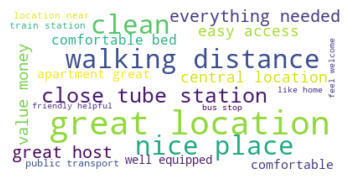

In [352]:
wordcloud = create_wordcloud(16817577, cluster_F, full_dataframe)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

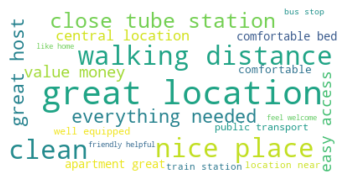

In [328]:
wordcloud = create_wordcloud_cl(243, full_dataframe)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 7.  Create unique listing_id to cluster id csv

In [353]:
cluster_F.head()

,listing_id,cluster,cluster_id
0,11551,L:Lambeth_P:expensive_S:small,287
1,53245,L:Lambeth_P:expensive_S:small,287
2,101083,L:Lambeth_P:expensive_S:small,287
3,131444,L:Lambeth_P:expensive_S:small,287
4,365933,L:Lambeth_P:expensive_S:small,287


In [354]:
cluster_F.duplicated().sum()

0

In [358]:
cluster_F.cluster_id.value_counts()

444    1039
392    1001
398     992
442     970
437     788
400     734
438     730
434     718
157     709
71      691
73      649
159     641
264     630
371     616
283     601
390     586
396     557
151     555
440     547
289     537
257     537
247     522
291     504
172     503
365     495
149     492
65      491
373     490
63      487
427     475
       ... 
187       2
123       2
267       2
77        2
203       2
210       2
386       2
384       1
51        1
406       1
27        1
143       1
319       1
220       1
171       1
3         1
89        1
303       1
104       1
332       1
115       1
135       1
412       1
20        1
26        1
344       1
376       1
336       1
113       1
305       1
Name: cluster_id, Length: 447, dtype: int64

In [355]:
cluster_F.to_csv('listing_to_cluster_id.csv')